In [11]:
# basic imports
import os, random
import numpy as np
import datetime as dt
import time
from scipy.fftpack import fft, ifft
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

# warnings
import warnings

warnings.filterwarnings('ignore')

# tensorflow
import tensorflow as tf

tf.keras.backend.clear_session()

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras.layers import Layer, Add

In [12]:
print(f" TensorFlow version is {tf.__version__}")
#print(f"Keras version is {tf.keras.__version__}")
print(tf.config.list_physical_devices())

 TensorFlow version is 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'), PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]


In [13]:
class Linear(Layer):
    """Define Linear layers"""

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        self.in_dims = in_features
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'
        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    #@tf.function
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class StableLinear(Layer):
    """Define Stable Linear layers"""

    def __init__(self, in_features, out_features):
        super(StableLinear, self).__init__()

        self.epsilon = 0.01
        self.w = self.add_weight(
            shape=(in_features, out_features),
            initializer='glorot_uniform',
            trainable=True
        )  # weights_initializer='glorot normal'

        self.b = self.add_weight(
            shape=(out_features,), initializer='zeros', trainable=True
        )  # bias_initializer='zeros'

    #@tf.function
    def call(self, inputs):
        w = self.weight_constraint(self.w)
        return tf.matmul(inputs, w) + self.b

    #@tf.function
    def weight_constraint(self, weight):
        delta = 1 - 2 * self.epsilon
        RtR = tf.matmul(tf.transpose(weight), weight)
        norm = tf.norm(RtR)

        #if norm > delta: RtR = delta ** (1 / 2) * RtR / (norm ** (1 / 2))
        RtR_new = tf.sqrt(delta) * RtR / tf.sqrt(norm)
        RtR_update = tf.minimum(RtR_new, RtR)
        #def f2(): return RtR
        #RtR = tf.cond(tf.greater(norm, delta), f1, f2)
        A = RtR_update + tf.eye(RtR.shape[0]) * self.epsilon
        return -A


class NaisNet(Model):
    """ Building NAIS_Net network using keras """

    def __init__(self, layers):
        super(NaisNet, self).__init__()

        self.layer1 = Linear(layers[0], layers[1])

        self.layer2 = StableLinear(layers[1], layers[2])
        self.layer2_input = Linear(layers[0], layers[2])

        self.layer3 = StableLinear(layers[2], layers[3])
        self.layer3_input = Linear(layers[0], layers[3])

        self.layer4 = StableLinear(layers[3], layers[4])
        self.layer4_input = Linear(layers[0], layers[4])

        self.layer5 = Linear(layers[4], layers[5])
        self.layer6 = Linear(layers[4], layers[6])

    # Building block for the NAIS-Net
    #@tf.function
    def call(self, x):
        """Process stages in the block"""

        u = x

        output = self.layer1(u)  # layer 1
        output = tf.sin(output)

        X1 = output
        output = self.layer2(output)  # layer 2
        output = Add()([self.layer2_input(u), output])
        output = tf.sin(output)
        output = Add()([X1, output])

        X2 = output
        output = self.layer3(output)  # layer 3
        output = Add()([self.layer3_input(u), output])
        output = tf.sin(output)
        output = Add()([X2, output])

        X3 = output
        output = self.layer4(output)  # layer 4
        output = Add()([self.layer4_input(u), output])
        output = tf.sin(output)
        output = Add()([X3, output])

        output1 = self.layer5(output)  # layer 5
        output2 = self.layer6(output)
        return output1, output2


class FBSNN(ABC):
    """Forward-Backward SDEs using NAIS-Net """

    def __init__(self, Xi, T, M, N, D, H, eta, pho, r, layers):    # , layer_phi

        self.Xi = Xi  # initial point

        self.T = T  # terminal time
        self.M = M  # number of trajectories
        self.N = N  # number of time snapshots
        self.D = D  # number of dimensions
        self.H = H  # Hurst exponent (0,1)
        self.eta = eta  # parameter for control volatility
        self.pho = tf.cast(pho, dtype=tf.float32) # correlation betwen two independent Wiener process
        self.epsilon_t = 0.09 # forward variance curve epsilon(t) - constant
        self.r = tf.cast(r, dtype=tf.float32)  # interest rate

        # Initialize NN
        #self.phi_input_shape = tf.cast(layers[0], dtype=tf.int32)
        #self.phi_output_shape= tf.cast(self.D, dtype=tf.int32)
        #self.phi_weight, self.phi_bias = self.init_wb([self.phi_input_shape, self.phi_output_shape])
        self.model = NaisNet(layers)
        #self.model_phi = NaisNet(layer_phi)

        # Record the loss
        self.training_loss = []
        self.iteration = []
        self.Y0_iter = []
        self.Du0_iter = []

    #def init_wb(self,size):
    #    xavier_stddev = tf.cast(tf.sqrt(tf.divide(2, tf.add(size[0], size[1]))),dtype=tf.float32)
    #    weight = tf.Variable(tf.random.truncated_normal([self.phi_input_shape, self.phi_output_shape],
    #                                           stddev=xavier_stddev), trainable=True, dtype=tf.float32)
        #weitht = self.xavier_init([self.phi_input_shape, self.phi_output_shape])
    #    bias = tf.Variable(tf.zeros([1, self.phi_output_shape]), dtype=tf.float32)
    #    return  weight, bias

    #def phi_tf(self,inputs):
    #    return tf.matmul(inputs, self.phi_weight) + self.phi_bias

    @tf.function
    def net_u(self, t, X):  # M x 1, M x D

        u, phi = self.model(tf.concat([t, X], 1))  # M x [1+D]
        #u = tf.expand_dims(y[:, 0], axis=-1)  # M x 1
        #phi = self.model_phi(tf.concat([t, X], 1)) # M x D
        #phi = self.phi_tf(tf.concat([t,X], 1))
        #phi = y[:, 1:] # M x D
        Du = tf.gradients(u, X)[0]  # M x D

        return u, phi, Du

    @tf.function
    def Dg_tf(self, X):  # M x D
        return tf.gradients(self.g_tf(X), X)[0]  # M x D

    #@tf.function
    def loss_function(self, t, W, B, Var, Xi):

        loss = 0
        X_list = []
        Y_list = []
        Tilde_Z_list = []
        Z_list = []
        Du_list = []


        t0 = t[:, 0, :]
        W0 = W[:, 0, :]
        B0 = B[:, 0, :]
        Var0 = Var[:, 0, :]

        X0 = tf.tile(Xi, [self.M, 1])  # M x D
        Y0, phi0, du0 = self.net_u(t0, X0)  # M x 1, M x D, M x D
        Z0 = self.Z_tf(Var0,du0) # M x D
        Tilde_Z0 = self.Z_tilde_tf(Var0, phi0, du0) # M x D

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)
        Tilde_Z_list.append(Tilde_Z0)
        Du_list.append(du0)

        for n in range(0, self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]
            B1 = B[:, n + 1, :]
            Var1 = Var[:, n + 1, :]
            BM = self.pho * (W1 - W0) + tf.sqrt(1 - self.pho**2) * (B1 - B0)
            X1 = X0 +self.mu_tf(t0, X0, Y0, du0) * (t1 - t0)  - Var0 * 0.5 * (t1 - t0) + tf.sqrt(Var0) * BM

            Y1_tilde = Y0 + self.F_tf(t0, X0, Y0, Z0, Tilde_Z0) * (t1 - t0) + tf.reduce_sum(
                tf.squeeze(tf.matmul(Z0, tf.expand_dims(B1 - B0, -1))), axis=1,
                keepdims=True) + tf.reduce_sum(
                tf.squeeze(tf.matmul(Tilde_Z0, tf.expand_dims(W1 - W0, -1))), axis=1, keepdims=True)

            Y1, phi1, du1 = self.net_u(t1, X1)
            Z1 = self.Z_tf(Var1,du1) # M x D
            Tilde_Z1 = self.Z_tilde_tf(Var1, phi1, du1) # M x D


            loss += tf.reduce_sum(tf.pow(Y1 - Y1_tilde, 2))

            t0 = t1
            W0 = W1
            B0 = B1
            Var0 = Var1
            du0 = du1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            Tilde_Z0 = Tilde_Z1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)
            Tilde_Z_list.append(Tilde_Z0)
            Du_list.append(du0)

        # 0.02 is the penalty parameters for the terminal conditions
        loss += 0.02 * tf.reduce_sum(tf.pow(Y1 - self.g_tf(X1), 2))
        loss += 0.02 * tf.reduce_sum(tf.pow(du1 - self.Dg_tf(X1), 2))
        loss += 0.02 * tf.reduce_sum(tf.pow(Tilde_Z1 - self.Z_tilde_tf(Var1, phi1, self.Dg_tf(X1)), 2))

        X = tf.stack(X_list, axis=1)
        Y = tf.stack(Y_list, axis=1)
        Z = tf.stack(Z_list, axis=1)
        Tilde_Z = tf.stack(Tilde_Z_list, axis=1)
        Du_t = tf.stack(Du_list, axis=1)
        #Y0 = tf.reduce_mean(Y, axis=0)

        return loss, X, Y, Y[0, 0, 0], Du_t

    def Z_tf(self, Var, Du):  # M x D
        return tf.sqrt((1 - self.pho**2) * Var) * Du

    def Z_tilde_tf(self, Var, phi, Du): # M x D
        return self.pho * tf.sqrt(Var) * Du + phi

    # Volterra process Using hybrid scheme
    def volterra(self):
        T = self.T
        M = self.M
        N = self.N
        D = self.D
        delta_t = T / N
        alpha = self.H - 0.5

        Dt = np.zeros((M, N + 1, 1))  # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D))  # M x (N+1) x D
        Dt[:, 1:, :] = delta_t
        DW[:, 1:, :] = np.sqrt(delta_t) * np.random.normal(size=(M, N, D))

        t_series = np.cumsum(Dt, axis=1)  # M x (N+1) x 1
        W_process = np.cumsum(DW, axis=1)  # M x (N+1) x D

        sigma = (2*alpha + 1)**0.5
        #kernal function
        def g_kernel(k):
            y = (k**(alpha+1) - (k-1)**(alpha+1)) / (alpha+1)
            b = np.power(y, 1/alpha)
            return np.power((b) * delta_t, alpha)

        #t_series, W_process = self.fetch_minibatch()

        tilde_X = np.zeros((M, N+1, D))
        tilde_X[:, 0 , :]= W_process[:, 0 , :]

        WN_tj_minus_1_1 = np.roll(W_process, shift=-1, axis=1) - W_process

        for m in range(M):
            for d in range(D):
                # first column for toeplitz matrix
                WN_j = WN_tj_minus_1_1[m, :-1, d]
                sigma_col = np.zeros((N))
                sigma_col[0] = np.power(delta_t/2, alpha) * sigma
                #
                for k in range(1, N):
                    g_b_star_k = g_kernel(k+1)
                    sigma_col[k] = sigma * g_b_star_k

                # FFT and dot
                WN_j_fft = fft(WN_j)
                sigma_fft = fft(sigma_col)
                convolved = ifft(WN_j_fft * sigma_fft)

                # capture real value
                tilde_X[m, 1:, d] = np.real(convolved)

        return t_series, W_process, tilde_X

    # Variace process
    def variance(self):

        t, W_s, D_hat_w = self.volterra()# M x (N+1) x D

        var = self.epsilon_t * np.exp(self.eta* D_hat_w -  0.5 * self.eta**2 * np.power(t, 2*self.H))

        return W_s, var

    #@tf.function
    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M, N + 1, 1))  # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D))  # M x (N+1) x D

        dt = T / N

        Dt[:, 1:, :] = dt
        DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))

        t = np.cumsum(Dt, axis=1)  # M x (N+1) x 1
        W = np.cumsum(DW, axis=1)  # M x (N+1) x D

        return t, W

    @tf.function
    def train_step(self, optimizers, t, w, b, var, Xi):
        # Optimizers
        optimizer = optimizers

        with tf.GradientTape() as tape:
            loss_value, X_pred, Y_pred, Y0_pred, Du0_pred = self.loss_function(t, w, b, var, Xi)

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        #optimizer.apply(grads, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))


        return loss_value, Y0_pred, Du0_pred

    #@tf.function
    def train(self, N_Iter, learning_rate):

        loss_temp = np.array([])
        Y0_pred_temp = np.array([])
        Du0_pred_temp = np.array([])

        # Optimizers
        #self.optimizer = AdamW(learning_rate=learning_rate, weight_decay=0.001)
        self.optimizer = Adam(learning_rate=learning_rate)

        start_time = time.time()
        ini_time = time.time()

        for it in range(N_Iter):

            t_batch, B_batch = self.fetch_minibatch()  # M x (N+1) x 1, M x (N+1) x D
            W_batch, Var_batch = self.variance() # M x (N+1) x D, M x (N+1) x D
            t_batch = tf.convert_to_tensor(t_batch, dtype=tf.float32)
            B_batch = tf.convert_to_tensor(B_batch, dtype=tf.float32)
            W_batch = tf.convert_to_tensor(W_batch, dtype=tf.float32)
            Var_batch = tf.convert_to_tensor(Var_batch, dtype=tf.float32)
            self.Xi = tf.convert_to_tensor(self.Xi, dtype=tf.float32)

            loss_value, Y0_pred, Du0_pred = self.train_step(self.optimizer, t_batch, W_batch, B_batch, Var_batch, self.Xi)

            if it % 100 == 0:
                elapsed = time.time() - start_time
                total_time = time.time() - ini_time
                print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Total Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_pred, elapsed, total_time, learning_rate))
                start_time = time.time()

            loss_temp = np.append(loss_temp, loss_value.numpy())
            Y0_pred_temp = np.append(Y0_pred_temp, Y0_pred.numpy())

            Du0 = tf.reduce_mean(Du0_pred, axis=0, keepdims=True)
            Du0_pred_temp = np.append(Du0_pred_temp, Du0.numpy()[0, 0])

            if it % 100 == 0:
                self.training_loss.append(loss_temp.mean())
                self.Y0_iter.append(Y0_pred_temp[-100:].mean())
                self.Du0_iter.append(Du0_pred_temp[-100:].mean())
                self.iteration.append(it)

            graph = np.stack((self.iteration, self.training_loss))
            Y0_iter = np.stack((self.iteration, self.Y0_iter))
            Du0_iter = np.stack((self.iteration, self.Du0_iter))

        return graph,Y0_iter, Du0_iter

    def predict(self, Xi_star, t_star, W_star, B_star, Var_star):
        t_star = tf.convert_to_tensor(t_star, dtype=tf.float32)
        W_star = tf.convert_to_tensor(W_star, dtype=tf.float32)
        Xi_star = tf.convert_to_tensor(Xi_star, dtype=tf.float32)
        B_star = tf.convert_to_tensor(B_star, dtype=tf.float32)
        Var_star = tf.convert_to_tensor(Var_star, dtype=tf.float32)

        loss, X_star, Y_star, Y0_pred, delta_star = self.loss_function(t_star, W_star, B_star, Var_star, Xi_star)

        return X_star, Y_star, delta_star

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def F_tf(self, t, X, Y, Z, Tilde_Z):  # M x 1, M x D, M x 1, M x D, M x D
        pass  # M x1

    @abstractmethod
    def g_tf(self, X):  # M x D
        pass  # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Du):  # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return tf.zeros([M, D])  # M x D
    ###########################################################################


In [14]:
class RoughBergomiModel(FBSNN):
    def __init__(self, Xi, T, M, N, D, H, eta, pho, r, layers):
        super().__init__(Xi, T, M, N, D, H, eta, pho, r, layers)

    def g_tf(self, X):  # M x D
        K = tf.tile(np.array([90.0], dtype=np.float32)[None, :], [self.M, 1])
        X = tf.reduce_mean(tf.exp(X + self.r * self.T), axis=1, keepdims = True)
        return tf.maximum(K - X, 0) # M x 1

    def mu_tf(self, t, X, Y, Du):  # M x 1, M x D, M x 1, M x D
        return super().mu_tf(t, X, Y, Du)  # M x D

    def F_tf(self, t, X, Y, Z, Tilde_Z):  # M x 1, M x D, M x 1, M x D, M x D
        return self.r * Y # M x1

    ###########################################################################

In [15]:
T = 1.0  # terminal time
M = 100  # number of trajectories
N = 50  # number of time snapshots
D = 20  # number of dimensions
H = 0.07  # Hurst exponent (0,1)
eta = 1.9  # parameter for control volatility
pho = -0.9  # correlation betwen two independent Wiener process
r = 0.05  # interest rate

Xi = np.array([np.log(100.0), np.log(50.0)] * int(D / 2))[None, :]

layers = [D+1] + 4 * [256] + [1] + [D]

model = RoughBergomiModel(Xi, T, M, N, D, H, eta, pho, r, layers)
graph, Y0_iter, delta_iter = model.train(2*10**4, 1e-3)

It: 0, Loss: 5.251e+07, Y0: 0.112, Time: 29.12, Total Time: 29.12, Learning Rate: 1.000e-03
It: 100, Loss: 8.185e+04, Y0: -0.860, Time: 42.96, Total Time: 72.08, Learning Rate: 1.000e-03
It: 200, Loss: 4.443e+04, Y0: -0.818, Time: 42.69, Total Time: 114.77, Learning Rate: 1.000e-03
It: 300, Loss: 5.232e+04, Y0: -0.644, Time: 41.12, Total Time: 155.89, Learning Rate: 1.000e-03
It: 400, Loss: 4.388e+04, Y0: -0.499, Time: 38.47, Total Time: 194.35, Learning Rate: 1.000e-03
It: 500, Loss: 6.098e+04, Y0: -0.312, Time: 38.28, Total Time: 232.63, Learning Rate: 1.000e-03
It: 600, Loss: 5.382e+04, Y0: -0.062, Time: 38.08, Total Time: 270.71, Learning Rate: 1.000e-03
It: 700, Loss: 3.927e+04, Y0: 0.095, Time: 38.28, Total Time: 308.99, Learning Rate: 1.000e-03
It: 800, Loss: 7.582e+04, Y0: 0.314, Time: 38.03, Total Time: 347.03, Learning Rate: 1.000e-03
It: 900, Loss: 2.732e+04, Y0: 0.497, Time: 38.45, Total Time: 385.47, Learning Rate: 1.000e-03
It: 1000, Loss: 3.480e+04, Y0: 0.735, Time: 39.6

In [16]:
np.random.seed(42)
t_test, B_test = model.fetch_minibatch()
W_test, Var_test = model.variance()

X_pred, Y_pred, delta_pred = model.predict(Xi, t_test, W_test, B_test, Var_test)
#Y0_test = 4.9550

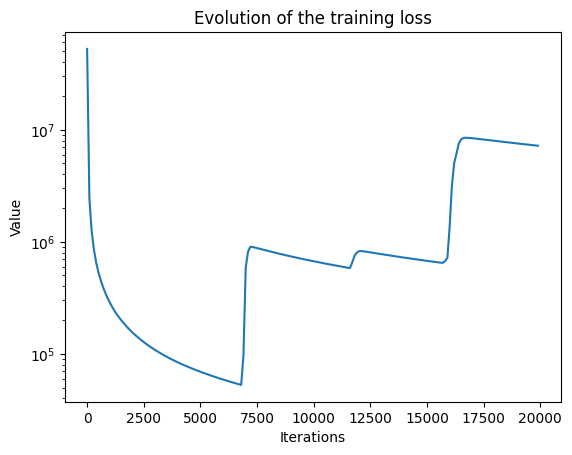

In [17]:
D = 20
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
plt.savefig(str(D) + 'train-loss' + 'RoughBergomiModel')

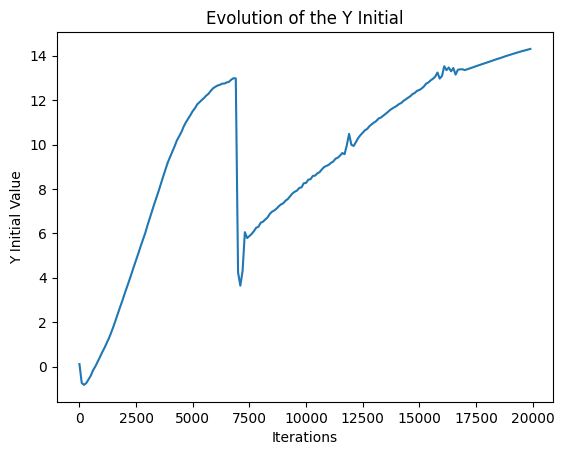

In [18]:
plt.figure()
plt.plot(Y0_iter[0], Y0_iter[1], label='Learned $Y_0$')
#plt.axhline(Y0_test, color='r', label='Exact $Y_0$')
plt.xlabel('Iterations')
plt.ylabel('Y Initial Value')
#plt.yscale("log")
plt.title('Evolution of the Y Initial')
plt.savefig(str(D) + ' Initial' + 'RoughBergomiModel')

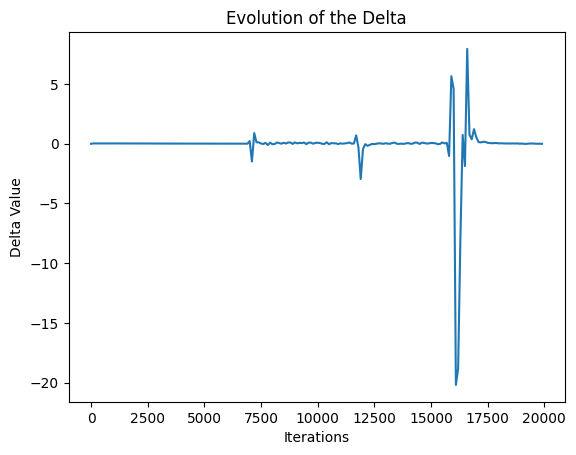

In [19]:
plt.figure()
plt.plot(delta_iter[0], delta_iter[1], label='Learned $Delta_T$')
plt.xlabel('Iterations')
plt.ylabel('Delta Value')
#plt.yscale("log")
plt.title('Evolution of the Delta')
plt.savefig(str(D) + 'Delta' + 'RoughBergomiModel')

In [20]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

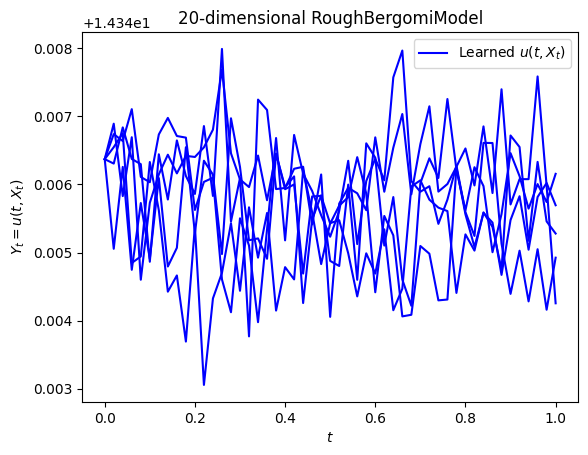

In [21]:
samples = 5
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional RoughBergomiModel')
plt.legend()
plt.savefig(str(D) +'-dimensional RoughBergomiModel' + 'traces')

In [22]:
!pip install tabulate

In [23]:
#. Monte Carlo Simulation
T_mc = 1.0  # terminal time
M_mc = 10000  # number of trajectories
N_mc = 50  # number of time snapshots
D_mc = 20  # number of dimensions
H_mc = 0.07  # Hurst exponent (0,1)
eta_mc = 1.9  # parameter for control volatility
pho_mc = -0.9  # correlation betwen two independent Wiener process
r_mc = 0.05  # interest rate

layers_mc = [D_mc+1] + 4 * [256] + [1] + [D_mc]

Xi_mc = np.array([np.log(100.0), np.log(50.0)] * int(D_mc/2) )[None, :]
model_mc = RoughBergomiModel(Xi_mc, T_mc, M_mc, N_mc, D_mc, H_mc, eta_mc, pho_mc, r_mc, layers_mc)

np.random.seed(42)
t_mc_test, B_mc_test = model_mc.fetch_minibatch()
W_mc_test, Var_mc_test = model_mc.variance()

def MC_simulation(t, W, B, Var, Xi):

    X_list = []

    t0 = t[:, 0, :]
    W0 = W[:, 0, :]
    B0 = B[:, 0, :]
    Var0 = Var[:, 0, :]

    X0 = tf.tile(Xi, [M_mc, 1])  # M x D
    X_list.append(X0)

    for n in range(0, N_mc):
        t1 = t[:, n + 1, :]
        W1 = W[:, n + 1, :]
        B1 = B[:, n + 1, :]
        Var1 = Var[:, n + 1, :]

        BM = pho_mc * (W1 - W0) + np.sqrt(1 - np.square(pho_mc)) * (B1 - B0)
        X1 = X0 - Var0 * 0.5 * (t1 - t0)+ np.sqrt(Var0) * BM

        t0 = t1
        W0 = W1
        B0 = B1
        Var0 = Var1
        X0 = X1

        X_list.append(X0)

    X = tf.stack(X_list, axis=1)
    return X

X_mc = MC_simulation(t_mc_test, W_mc_test, B_mc_test, Var_mc_test, Xi_mc)
K_mc = np.tile(np.array([90.0], dtype=np.float32)[None, :], [M_mc, 1])
S_T_mc = np.mean(np.exp(X_mc[:, -1, :] + r_mc * T_mc), axis=1, keepdims = True)
put_option_mc = np.mean(np.maximum(K_mc - S_T_mc, 0.0), axis=0) * np.exp(-r_mc * T_mc)

In [24]:
Y_pred_mean = np.mean(Y_pred, axis=0)
Y_pred_std = np.std(Y_pred, axis=0)
error = Y_pred_mean[0, 0] - put_option_mc
#print('Y0_mean is: {}'.format(Y_pred_mean[0, 0]))
#print('Y0_exact is: {}'.format(Y0_test))
#print('Y0_std is: {}'.format(Y_pred_std[0, 0]))
#print('Relative Error is: {}'.format(error))

In [25]:
from tabulate import tabulate
table = {'reference value': put_option_mc, 'Y0_mean': Y_pred_mean[0, :].tolist(), 'Y0_std': Y_pred_std[0, :].tolist(), 'relative error': error}
print(tabulate(table, headers='keys', tablefmt='github'))

|   reference value |   Y0_mean |      Y0_std |   relative error |
|-------------------|-----------|-------------|------------------|
|           13.9343 |   14.3464 | 1.52588e-05 |         0.412048 |
